In [135]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
import numpy as np

In [94]:
import pandas as pd
test = pd.read_csv('NB15_testing-set.csv')
train = pd.read_csv('NB15_training-set.csv')
feature_desc = pd.read_csv('NB15_features.csv', encoding='cp1252')

In [107]:
feature_desc

,No.,Name,Type,Description
0,1,srcip,nominal,Source IP address
1,2,sport,integer,Source port number
2,3,dstip,nominal,Destination IP address
3,4,dsport,integer,Destination port number
4,5,proto,nominal,Transaction protocol
5,6,state,nominal,Indicates to the state and its dependent proto...
6,7,dur,Float,Record total duration
7,8,sbytes,Integer,Source to destination transaction bytes
8,9,dbytes,Integer,Destination to source transaction bytes
9,10,sttl,Integer,Source to destination time to live value


In [95]:
#isolate + clean features
features = [
    'attack_cat','proto', 'is_ftp_login', 'dur', 'response_body_len']

train_encoded = train[features]
label_encoders = {}
for column in train_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    train_encoded[column] = le.fit_transform(train_encoded[column].astype(str))
    label_encoders[column] = le

test_encoded = test[features]
for column in test_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    test_encoded[column] = le.fit_transform(test_encoded[column].astype(str))
    label_encoders[column] = le

X_train = train_encoded
X_test =  test_encoded

y_train = train[['label']]
y_test = test[['label']]

/var/folders/ng/92pv0x_11vj5rbbqhrl2rzp00000gn/T/ipykernel_53714/1825902820.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_encoded[column] = le.fit_transform(train_encoded[column].astype(str))
/var/folders/ng/92pv0x_11vj5rbbqhrl2rzp00000gn/T/ipykernel_53714/1825902820.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_encoded[column] = le.fit_transform(train_encoded[column].astype(str))
/var/folders/ng/92pv0x_11vj5rbbqhrl2rzp00000gn/T/ipykernel_53714/1825902820.py:15: SettingWithCopyWarnin

In [96]:
test.shape
train.shape


(175341, 45)

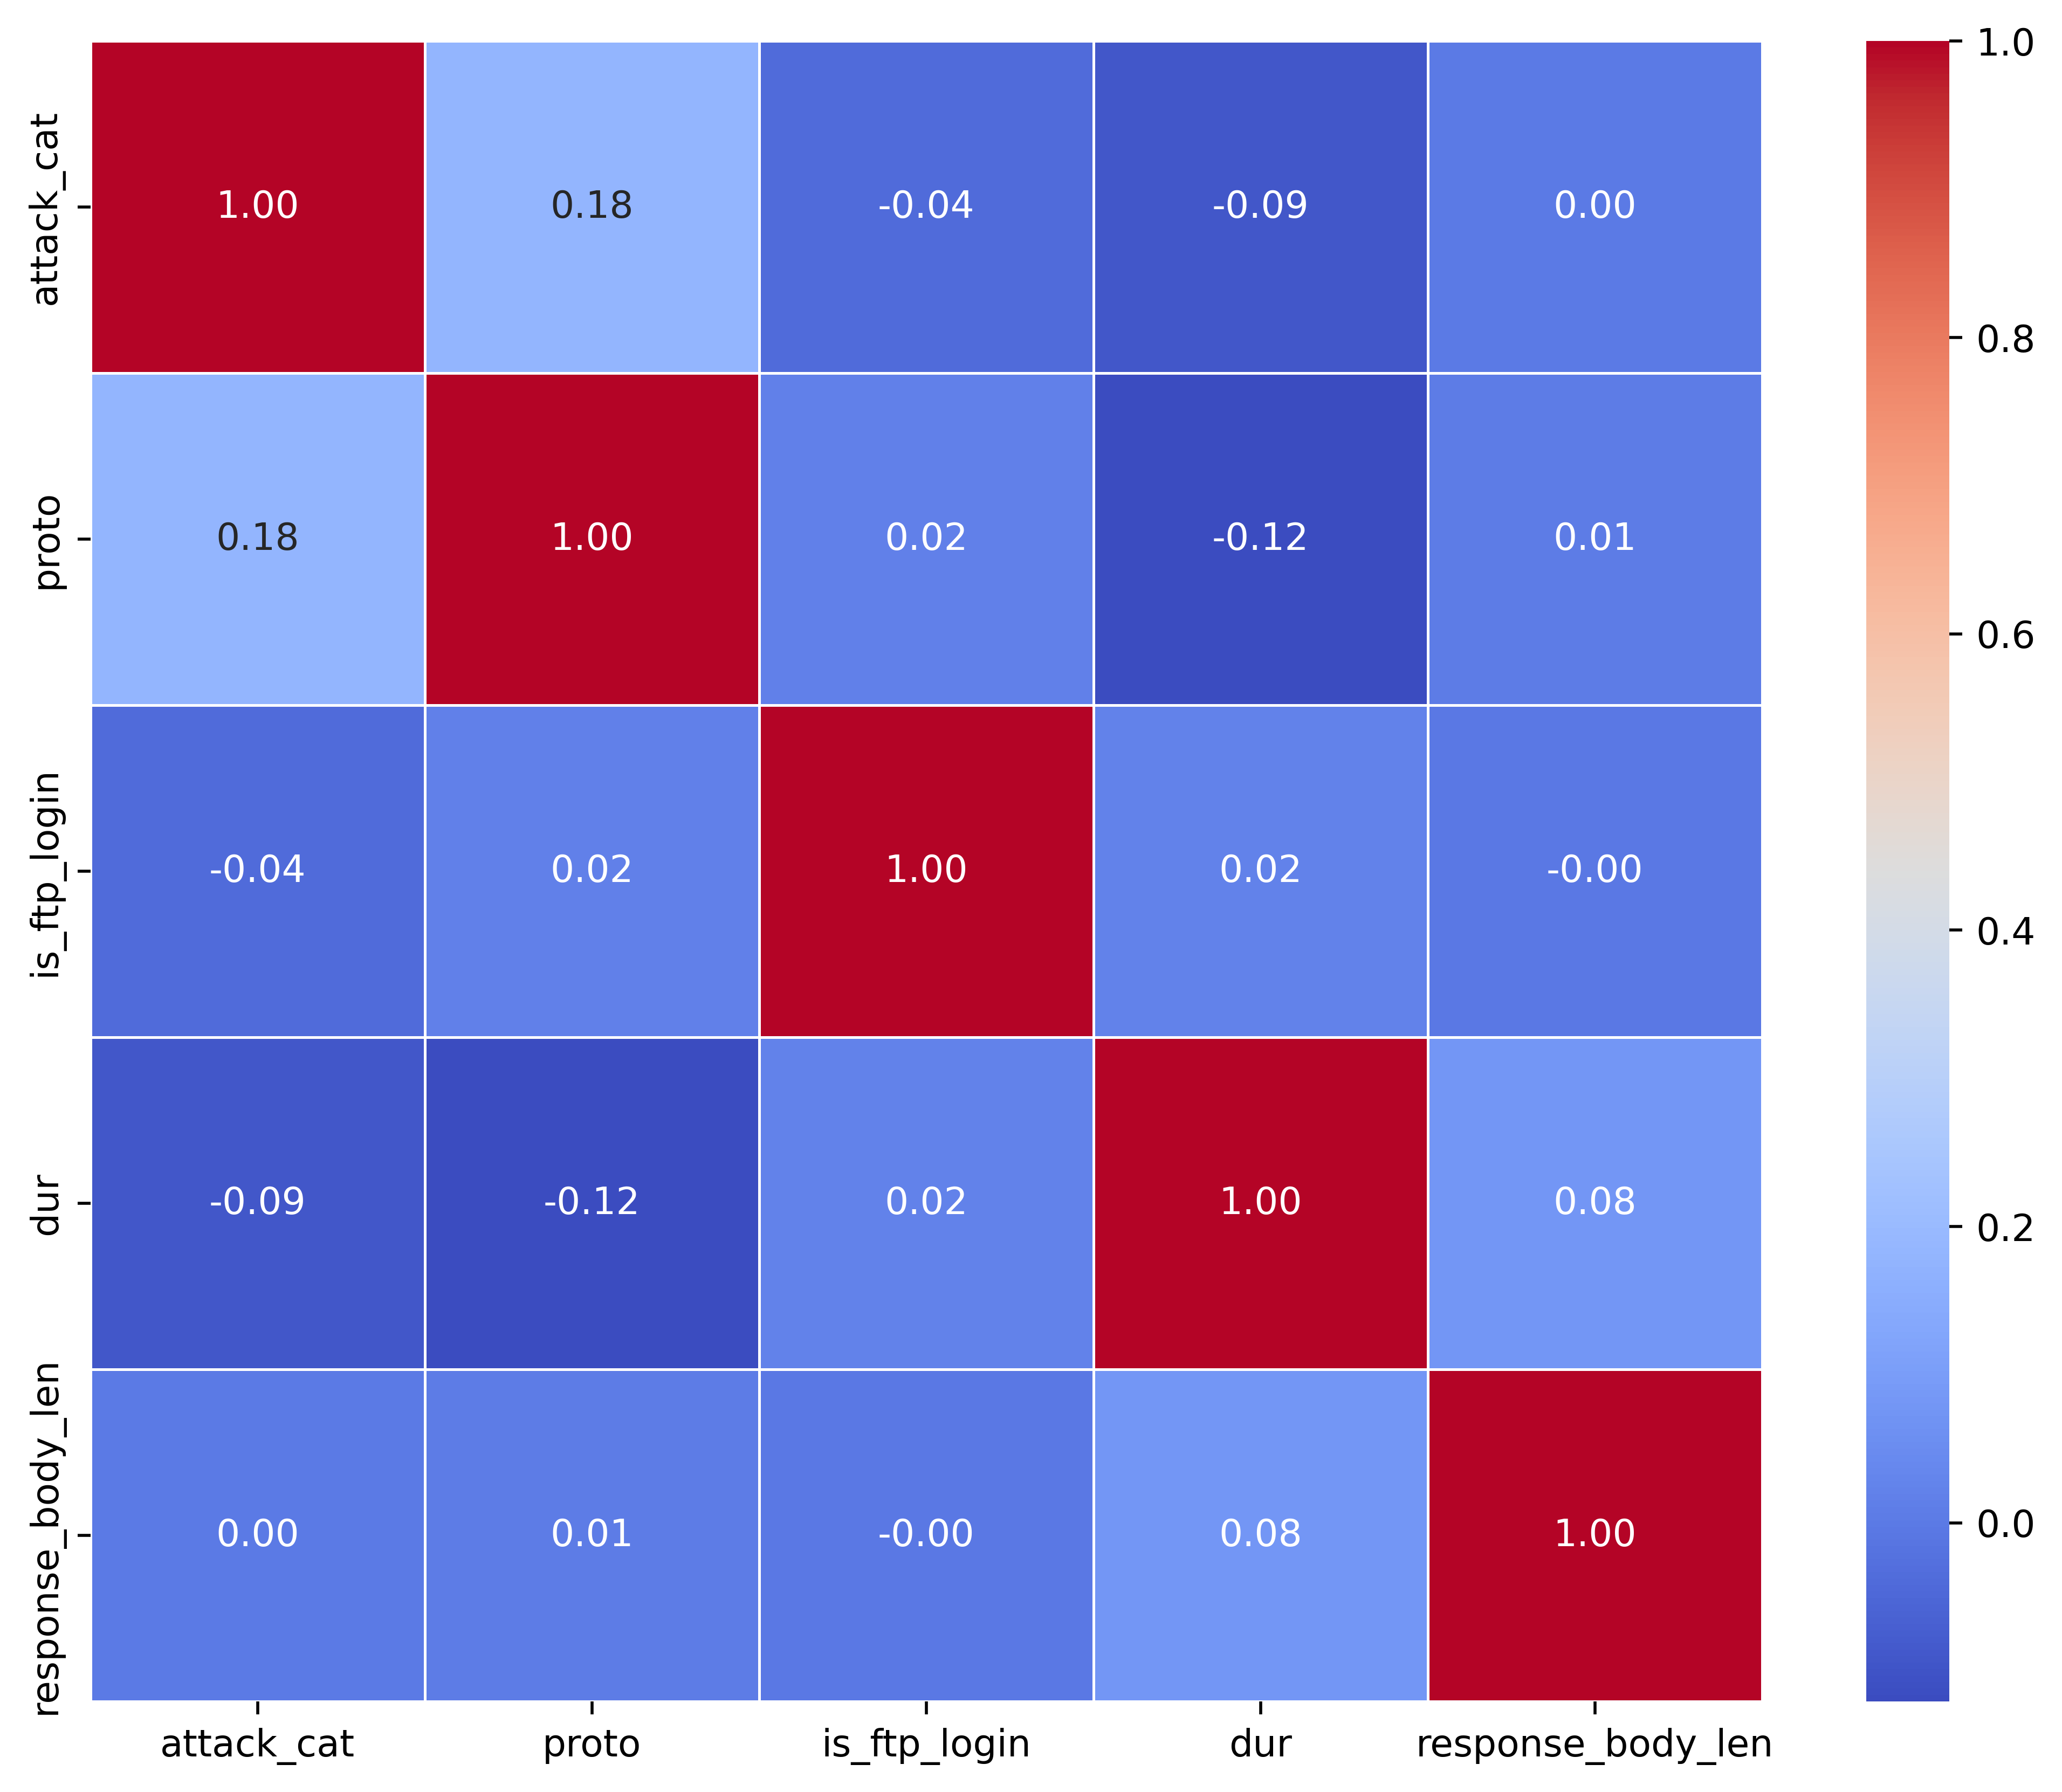

In [97]:
#correlation matrix
df = pd.concat([X_train, X_test], ignore_index=True)
correlation_matrix = df.corr()
plt.figure(figsize=(10,8), dpi =500)
sns.heatmap(correlation_matrix,annot=True,fmt=".2f", linewidth=.5, cmap = 'coolwarm')
plt.show()

/Users/evahuang/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/evahuang/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0     0.9042    1.0000    0.9497     37000
           1     1.0000    0.9135    0.9548     45332

    accuracy                         0.9524     82332
   macro avg     0.9521    0.9568    0.9523     82332
weighted avg     0.9570    0.9524    0.9525     82332



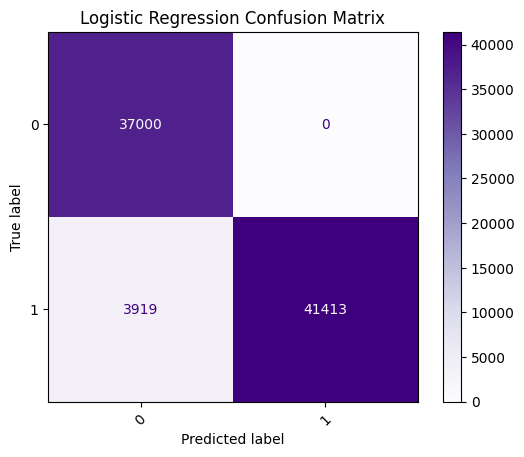

In [118]:
#logistic regression
logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train, y_train)
y_pred_lg = logreg.predict(X_test)
acc_lg = accuracy_score(y_test, y_pred_lg)
f1_lg = f1_score(y_test, y_pred_lg, average='weighted')

print("\nClassification Report for Logistic Regression:\n", classification_report(y_test, y_pred_lg, digits=4, zero_division=0))

cm_lg = confusion_matrix(y_test, y_pred_lg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lg)
disp.plot(cmap='Purples', xticks_rotation=45)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

/Users/evahuang/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Classification Report for Gaussian Naive Bayes:
               precision    recall  f1-score   support

           0     0.8829    0.9736    0.9260     37000
           1     0.9765    0.8946    0.9337     45332

    accuracy                         0.9301     82332
   macro avg     0.9297    0.9341    0.9299     82332
weighted avg     0.9344    0.9301    0.9303     82332



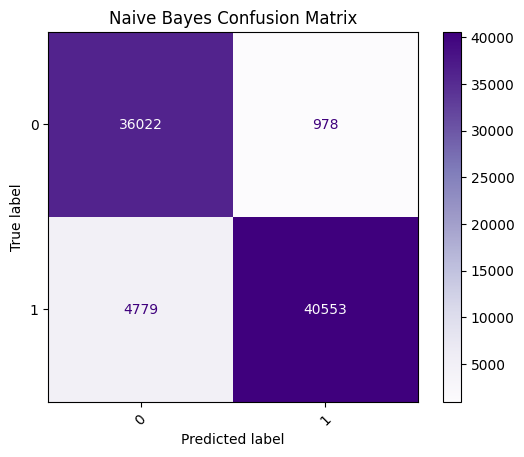

In [117]:
#naive bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
cm_nb = confusion_matrix(y_test, y_pred_nb)
acc_nb = accuracy_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb, average='weighted')

print("\nClassification Report for Gaussian Naive Bayes:\n", classification_report(y_test, y_pred_nb, digits=4, zero_division=0))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nb)
disp.plot(cmap='Purples', xticks_rotation=45)
plt.title("Naive Bayes Confusion Matrix")
plt.show()

/Users/evahuang/Library/Python/3.9/lib/python/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)



Classification Report using KNN:
               precision    recall  f1-score   support

           0     0.9950    0.1936    0.3242     37000
           1     0.6029    0.9992    0.7520     45332

    accuracy                         0.6372     82332
   macro avg     0.7989    0.5964    0.5381     82332
weighted avg     0.7791    0.6372    0.5597     82332



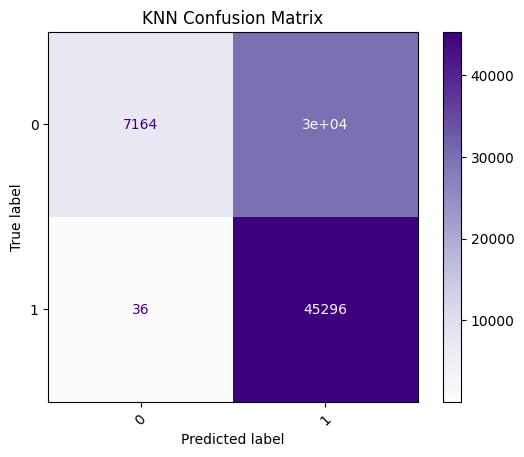

In [116]:
knn = KNeighborsClassifier(n_neighbors=5, weights = "distance")
    
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

print("\nClassification Report using KNN:\n", classification_report(y_test, y_pred_knn, digits=4, zero_division=0))

cm_knn = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn)
disp.plot(cmap='Purples', xticks_rotation=45)
plt.title("KNN Confusion Matrix")
plt.show()

In [128]:
#random forest
#forest = RandomForestClassifier(n_estimators=100, random_state=42)
#forest.fit(X_train, y_train)

# Predict and evaluate
#y_pred_f = forest.predict(X_test)
#acc = accuracy_score(y_test, y_pred_f)
#f1 = f1_score(y_test, y_pred_f, average='weighted')
#cm_f = confusion_matrix(y_test, y_pred_f)

#print("\nClassification Report for Random Forest:\n", classification_report(y_test, y_pred_f, digits=4, zero_division=0))

# Confusion matrix
#ConfusionMatrixDisplay.from_estimator(forest, X_test, y_test, display_labels=[0, 1], cmap=plt.cm.Blues)
#plt.title("Confusion Matrix - Random Forest")
#plt.show()
#scores = cross_val_score(forest,X_test,y_test, cv=5)
#print("CV accuracy:", scores.mean())

In [129]:
#extremely random trees
# Initialize the Extremely Randomized Trees classifier
#clf = ExtraTreesClassifier(n_estimators=100, random_state=42)

# Train the classifier
#clf.fit(X_train, y_train)
#y_pred_clf = clf.predict(X_test)
#acc = accuracy_score(y_test, y_pred_clf)
#f1 = f1_score(y_test, y_pred_clf, average='weighted')
#cm_clf = confusion_matrix(y_test, y_pred_clf)

#print("\nClassification Report for using CLF: \n", classification_report(y_test, y_pred_clf, digits=4, zero_division=0))

#disp = ConfusionMatrixDisplay(confusion_matrix=cm_clf)
#disp.plot(cmap='Blues', xticks_rotation=45)
#plt.title("CLF Confusion Matrix")
#plt.show()

In [120]:
#try mlp again
mlp = models.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Single neuron for binary output
])

# Compile model
mlp.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train model
mlp.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.7164 - loss: 46.3561 - val_accuracy: 0.9356 - val_loss: 5.2211
Epoch 2/20
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9052 - loss: 25.8891 - val_accuracy: 0.9912 - val_loss: 1.7884
Epoch 3/20
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9833 - loss: 11.0910 - val_accuracy: 0.9834 - val_loss: 6.3454
Epoch 4/20
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9847 - loss: 2.6061 - val_accuracy: 0.9936 - val_loss: 0.2166
Epoch 5/20
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9888 - loss: 0.2738 - val_accuracy: 0.9956 - val_loss: 0.0143
Epoch 6/20
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9875 - loss: 0.0263 - val_accuracy: 0.9839 - val_loss: 0.0383
Epoch 7/20
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9862 - loss: 0.0282 - val_accuracy: 0.9958 - val_loss: 0.0159
Epoch 8/20
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9858 - loss

2573/2573 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

Classification Report for MLP: 
               precision    recall  f1-score   support

           0     0.9834    0.9999    0.9916     37000
           1     1.0000    0.9862    0.9930     45332

    accuracy                         0.9924     82332
   macro avg     0.9917    0.9931    0.9923     82332
weighted avg     0.9925    0.9924    0.9924     82332



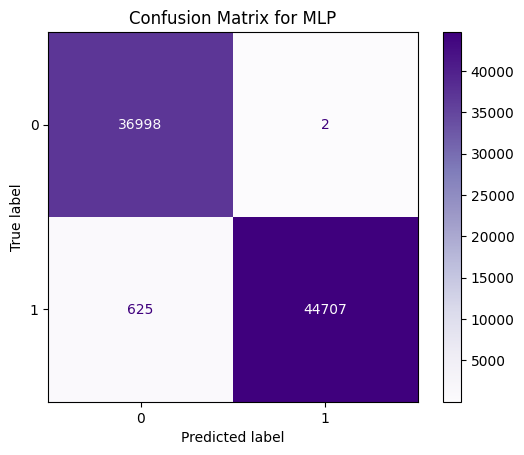

In [121]:
y_pred_prob = mlp.predict(X_test)

# Convert probabilities to class labels (threshold = 0.5)
y_pred_mlp = (y_pred_prob > 0.5).astype("int32")
acc_mlp = accuracy_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp, average='weighted')

# Classification report
print("\nClassification Report for MLP: \n", classification_report(y_test, y_pred_mlp, digits=4, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_mlp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Purples)
plt.title("Confusion Matrix for MLP")
plt.show()

In [ ]:
#pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [137]:
#xgboost
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

#smote = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize and train XGBoost model
#xgb  = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
#xgb.fit(X_train_resampled, y_train_resampled)

# Predict
#y_pred_xgb = xgb.predict(X_test)
#acc_xgb = accuracy_score(y_test, y_pred_xgb)
#f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

# Evaluation
#print(classification_report(y_test, y_pred_xgb))

# Confusion matrix
#ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test, display_labels=[0, 1], cmap=plt.cm.Blues)
#plt.title("Confusion Matrix - XGBoost")
#plt.show()

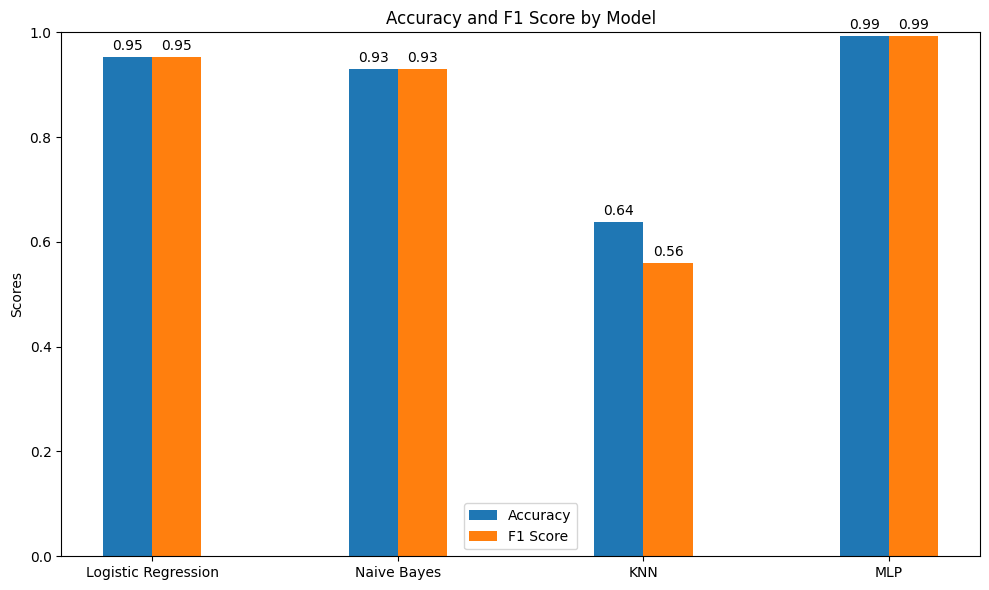

In [147]:
#boxplot comparison
x = np.arange(4)
lg = [acc_lg, f1_lg]
nb = [acc_nb, f1_nb]
knn = [acc_knn, f1_knn]
mlp = [acc_mlp, f1_mlp]

models = ['Logistic Regression', 'Naive Bayes', 'KNN', 'MLP']
accuracy = [lg[0], nb[0], knn[0], mlp[0]]
f1_score = [lg[1], nb[1], knn[1], mlp[1]]

x = np.arange(len(models))  # label locations
width = 0.2  # bar width

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, accuracy, width, label='Accuracy')
rects2 = ax.bar(x + width/2, f1_score, width, label='F1 Score')

# Add some labels and title
ax.set_ylabel('Scores')
ax.set_title('Accuracy and F1 Score by Model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1)
ax.legend()

# Optional: Add value labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),  # vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()  
